In [106]:
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort
import tqdm
import cv2

detect_model_path = '../DetectAndCompute.onnx'  # python .\export.py --dynamic --top_k 1024 --opset 17 --xfeat_only_model_detectAndCompute --export_path ./DetectAndCompute.onnx
match_model_path = '../Match.onnx'   # python .\export.py --dynamic --top_k 1024 --opset 17 --xfeat_only_model_match --export_path ./Match.onnx

#Load some example images
im1 = cv2.imread('../assets/ref.png', cv2.IMREAD_COLOR)
im2 = cv2.imread('../assets/tgt.png', cv2.IMREAD_COLOR)

In [107]:
def draw_keypoints(image, keypoints, scores):
    for i in range(keypoints.shape[0]):
        x, y = keypoints[i]
        cv2.circle(image, (int(x), int(y)), 1, np.array([0, 0, 255]) * scores[i], -1)
    return image

In [108]:
def warp_corners_and_draw_matches(ref_points, dst_points, img1, img2):
    # Calculate the Homography matrix
    H, mask = cv2.findHomography(ref_points, dst_points, cv2.USAC_MAGSAC, 3.5, maxIters=1_000, confidence=0.999)
    mask = mask.flatten()

    # Get corners of the first image (image1)
    h, w = img1.shape[:2]
    corners_img1 = np.array([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]], dtype=np.float32).reshape(-1, 1, 2)

    # Warp corners to the second image (image2) space
    warped_corners = cv2.perspectiveTransform(corners_img1, H)

    # Draw the warped corners in image2
    img2_with_corners = img2.copy()
    for i in range(len(warped_corners)):
        start_point = tuple(warped_corners[i-1][0].astype(int))
        end_point = tuple(warped_corners[i][0].astype(int))
        cv2.line(img2_with_corners, start_point, end_point, (0, 255, 0), 4)  # Using solid green for corners

    # Prepare keypoints and matches for drawMatches function
    keypoints1 = [cv2.KeyPoint(float(p[0]), float(p[1]), 5) for p in ref_points]
    keypoints2 = [cv2.KeyPoint(float(p[0]), float(p[1]), 5) for p in dst_points]
    matches = [cv2.DMatch(i,i,0) for i in range(len(mask)) if mask[i]]

    # Draw inlier matches
    img_matches = cv2.drawMatches(img1, keypoints1, img2_with_corners, keypoints2, matches, None,
                                  matchColor=(0, 255, 0), flags=2)

    return img_matches

In [109]:
detect_ort_session = ort.InferenceSession(detect_model_path, providers=['CPUExecutionProvider'])
match_ort_session = ort.InferenceSession(match_model_path, providers=['CPUExecutionProvider'])

# print the input,output names and shapes
print("detect model info:")
for i in range(len(detect_ort_session.get_inputs())):
    print(f"Input name: {detect_ort_session.get_inputs()[i].name}, shape: {detect_ort_session.get_inputs()[i].shape}")
for i in range(len(detect_ort_session.get_outputs())):
    print(f"Output name: {detect_ort_session.get_outputs()[i].name}, Data type: {detect_ort_session.get_outputs()[i].type}, shape: {detect_ort_session.get_outputs()[i].shape}")

print("match model info:")
for i in range(len(match_ort_session.get_inputs())):
    print(f"Input name: {match_ort_session.get_inputs()[i].name}, shape: {match_ort_session.get_inputs()[i].shape}")
for i in range(len(match_ort_session.get_outputs())):
    print(f"Output name: {match_ort_session.get_outputs()[i].name}, Data type: {match_ort_session.get_outputs()[i].type} shape: {match_ort_session.get_outputs()[i].shape}")


# providers = [
#     ('TensorrtExecutionProvider', { 
#         'device_id': 0,
#         'trt_max_workspace_size': 1 * 1024 * 1024 * 1024,
#         'trt_fp16_enable': True,
#         'trt_engine_cache_enable': True,
#         'trt_engine_cache_path': './trt_engine_cache',
#         'trt_engine_cache_prefix': 'xfeat',
#         'trt_dump_subgraphs': False,
#         'trt_timing_cache_enable': True,
#         'trt_timing_cache_path': './trt_engine_cache',
#         #'trt_builder_optimization_level': 3,
#     }),
#     ('CUDAExecutionProvider', {
#         'device_id': 0,
#         'gpu_mem_limit': 1 * 1024 * 1024 * 1024,
#     }),
#     ('CPUExecutionProvider',{ 
#     })
# ]
# ort_session = ort.InferenceSession(detect_model_path, providers=providers)

detect model info:
Input name: images, shape: [1, 3, 'height', 'width']
Input name: top_k, shape: []
Output name: keypoints, Data type: tensor(int64), shape: ['ScatterNDkeypoints_dim_0', 'ScatterNDkeypoints_dim_1', 2]
Output name: scores, Data type: tensor(float), shape: ['Slicescores_dim_0', 'Slicescores_dim_1']
Output name: descriptors, Data type: tensor(float), shape: ['Divdescriptors_dim_0', 'Divdescriptors_dim_1', 64]
match model info:
Input name: feats1, shape: ['num_descriptors', 64]
Input name: feats2, shape: ['num_descriptors', 64]
Input name: threshold, shape: []
Output name: indexes1, Data type: tensor(int64) shape: ['GatherNDindexes1_dim_0']
Output name: indexes2, Data type: tensor(int64) shape: ['GatherNDindexes1_dim_0']


# Input

In [110]:
input_array_1 = im1.transpose(2, 0, 1).astype(np.float32)
input_array_1 = np.expand_dims(input_array_1, axis=0)

input_array_2 = im2.transpose(2, 0, 1).astype(np.float32)
input_array_2 = np.expand_dims(input_array_2, axis=0)

top_k = np.array(1024, dtype=np.int64)

inputs1 = {
    detect_ort_session.get_inputs()[0].name: input_array_1,
    detect_ort_session.get_inputs()[1].name: top_k,
}

inputs2 = {
    detect_ort_session.get_inputs()[0].name: input_array_2,
    detect_ort_session.get_inputs()[1].name: top_k,
}

# Run

In [111]:
outputs1 = detect_ort_session.run(None, inputs1)
outputs2 = detect_ort_session.run(None, inputs2)

In [112]:
for i in range(len(outputs1)):
    print(f"Output1 name: {detect_ort_session.get_outputs()[i].name}, shape: {outputs1[i].shape}")

for i in range(len(outputs2)):
    print(f"Output2 name: {detect_ort_session.get_outputs()[i].name}, shape: {outputs2[i].shape}")

Output1 name: keypoints, shape: (1, 256, 2)
Output1 name: scores, shape: (1, 256)
Output1 name: descriptors, shape: (1, 256, 64)
Output2 name: keypoints, shape: (1, 256, 2)
Output2 name: scores, shape: (1, 256)
Output2 name: descriptors, shape: (1, 256, 64)


In [113]:
keypoints1 = outputs1[0]
scores1 = outputs1[1]
descriptors1 = outputs1[2]

keypoints2 = outputs2[0]
scores2 = outputs2[1]
descriptors2 = outputs2[2]

valid1 = scores1 > 0.0
valid2 = scores2 > 0.0

keypoints1 = keypoints1[valid1]
scores1 = scores1[valid1]
descriptors1 = descriptors1[valid1]

keypoints2 = keypoints2[valid2]
scores2 = scores2[valid2]
descriptors2 = descriptors2[valid2]

print('img1 detect info:')
print('keypoints', keypoints1.shape)
print('scores', scores1.shape)
print('descriptors', descriptors1.shape)

print('img2 detect info:')
print('keypoints', keypoints2.shape)
print('scores', scores2.shape)
print('descriptors', descriptors2.shape)

img1 detect info:
keypoints (256, 2)
scores (256,)
descriptors (256, 64)
img2 detect info:
keypoints (256, 2)
scores (256,)
descriptors (256, 64)


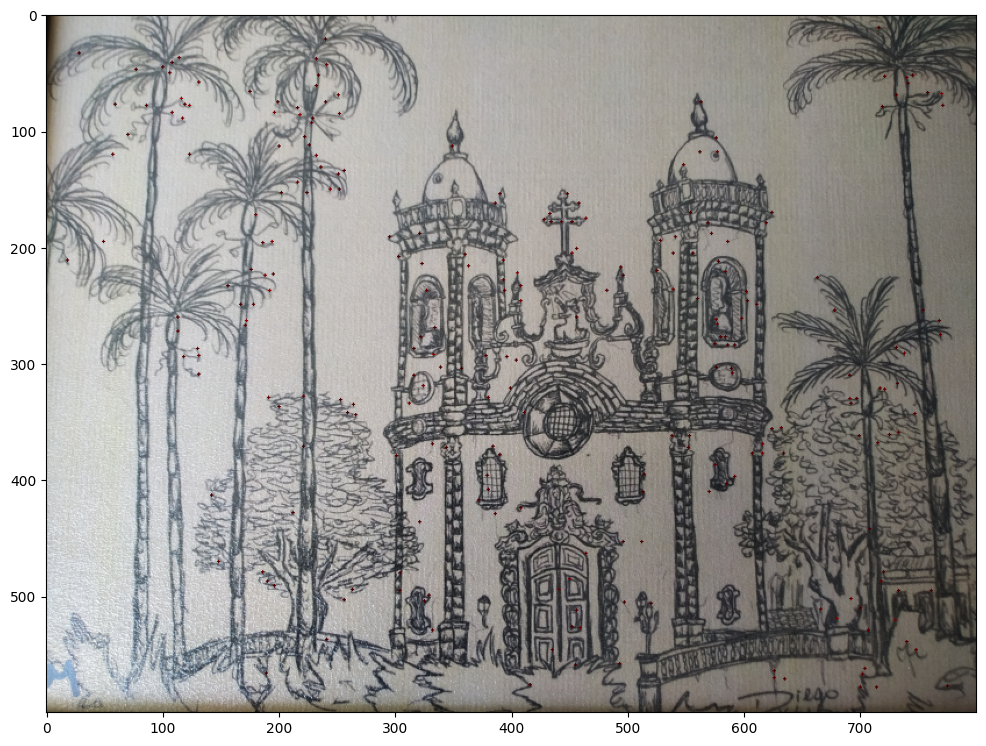

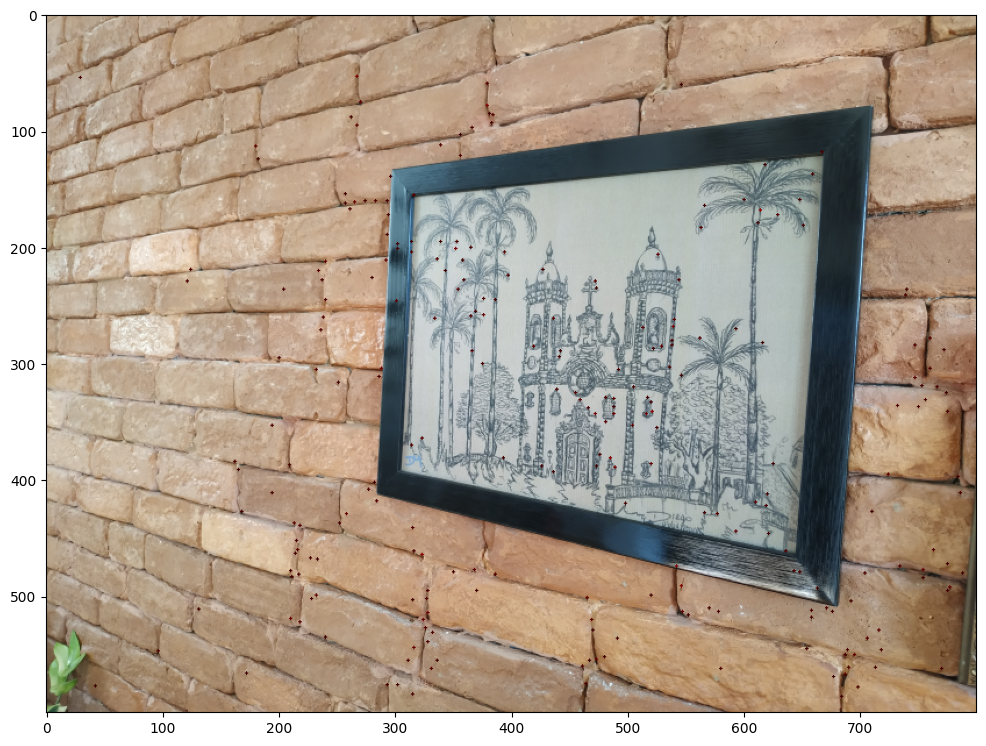

In [114]:
canvas1 = draw_keypoints(im1.copy(), keypoints1, scores1)
canvas2 = draw_keypoints(im2.copy(), keypoints2, scores2)
plt.figure(figsize=(12,12))
plt.imshow(canvas1[..., ::-1])

plt.figure(figsize=(12,12))
plt.imshow(canvas2[..., ::-1])

plt.show()
plt.close()

In [115]:
threshold = np.array(0.82, dtype=np.float32)
match_inputs = {
    match_ort_session.get_inputs()[0].name: descriptors1,
    match_ort_session.get_inputs()[1].name: descriptors2,
    match_ort_session.get_inputs()[2].name: threshold,
}

match_output = match_ort_session.run(None, match_inputs)

for i in range(len(match_output)):
    print(f"Output name: {match_ort_session.get_outputs()[i].name}, shape: {match_output[i].shape}")

Output name: indexes1, shape: (10,)
Output name: indexes2, shape: (10,)


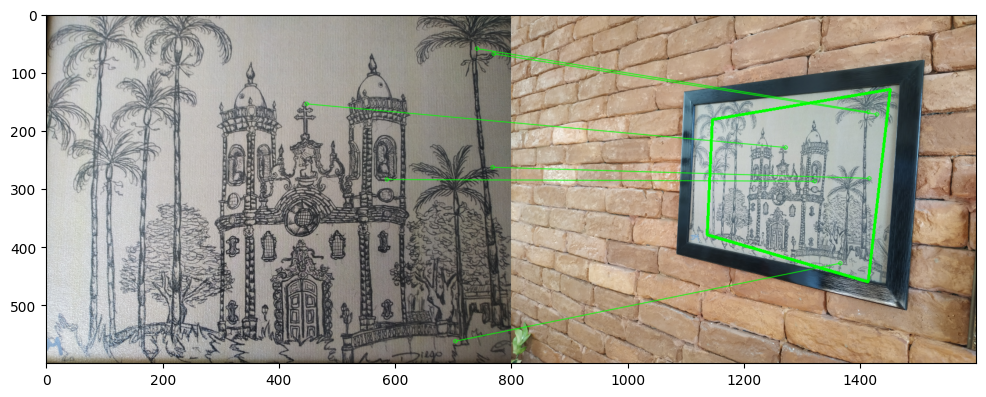

In [116]:
matched_points1 = keypoints1[match_output[0]]
matched_points2 = keypoints2[match_output[1]]

img_matches = warp_corners_and_draw_matches(matched_points1, matched_points2, im1, im2)

plt.figure(figsize=(12,12))
plt.imshow(img_matches[..., ::-1])
plt.show()
plt.close()


In [117]:
import time

# Run the model 100 times to get an average time
loop = 100
start = time.perf_counter()
for i in tqdm.tqdm(range(loop)):
    _ = detect_ort_session.run(None, inputs1)
    _ = detect_ort_session.run(None, inputs2)
    _ = match_ort_session.run(None, match_inputs)
    
duration = time.perf_counter()-start

print(f"Average time per batch: {duration/loop:.4f} seconds")
print(f"Average time per image: {duration/loop:.4f} seconds")
print(f"Average FPS per image: {loop/duration:.4f}")

100%|██████████| 100/100 [00:05<00:00, 19.21it/s]

Average time per batch: 0.0521 seconds
Average time per image: 0.0521 seconds
Average FPS per image: 19.2020
